<a href="https://colab.research.google.com/github/sohaamir/MRICN/blob/main/fc_tutorial/fc_conceptual_overview.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MRICN Tutorial: Conceptual introduction to functional connectivity

The brain if often described as a 'connectome' that is it's regions are connected to each other, both structurally and functionally. Diffusion MRI was a method by which you could measure the former, whilst functional connectivity is a way by which we can do the latter.

**Functional connectivity** is a broad definition, and has many different statistical methodologies under it's umbrella. For the sake of this tutorial however, we will stick to the most rudimentary definition: a correlation between two time-series (voxel or region-wise) during a scan.

In this notebook, we will walk through the basics of functional connectivity analysis, using an example dataset from the `nilearn` package.

Credits to Lucas Snoek's [notebook](https://colab.research.google.com/github/lukassnoek/nilearn-tutorial/blob/master/nilearn.ipynb#scrollTo=yjuks83DqfiY) on `nilearn` and the official `nilearn` [guide](https://nilearn.github.io/dev/connectivity/functional_connectomes.html) to functional connectivity analysis.

Before we get started, let's load up some programming music...

In [ ]:
from IPython.display import YouTubeVideo

# Embed the YouTube video
YouTubeVideo('jfKfPfyJRdk')

## 1. Install the necessary packages

We will need to install/import a bunch of packages including:

*   `nilearn` to work with our imaging data
*   `matplotlib` for plotting
*   `numpy` and `scipy` for mathsy stuff





In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
# Install necessary packages
%%capture
!pip install matplotlib nilearn

import nilearn as nil
import numpy as np
import matplotlib.pyplot as plt
import scipy

## 2. Load the data

From `nilearn`, we can import 'resting-state' fMRI data from the [Richardson dataset](https://openneuro.org/datasets/ds000228/versions/1.0.0) where 'children and adults watched Disney Pixar’s “Partly Cloudy” while lying in the scanner. There was no task; participants were simply instructed to lie still and watch the movie'.

Movie-watching has recently become an alternative paradigm to conventional 'resting-state' paradigms, see [(Finn & Bandettini, 2021)](https://www.sciencedirect.com/science/article/pii/S1053811921002408) for more information.

For the purposes of this notebook, it doesn't matter too much what data we have, so long as it's functional.

Because this is just an example, we will just analyse a single participant's scan. In the code below, we fetch both a brain atlas (Harvard-Oxford) and a single subject's fMRI data. We then create a 'masker object' (i.e., a mask) using the atlas, and then apply the mask to extract the time series data from the fMRI data for al regions in the atlas while regressing out confounding variables.

As the functional data is already registered to standard space, we load the Harvard-Oxford atlas and define voxels within the brain as exclusively belonging to different regions of the atlas.

In [ ]:
from nilearn import datasets
from nilearn.maskers import NiftiLabelsMasker

dataset = datasets.fetch_atlas_harvard_oxford("cort-maxprob-thr25-2mm")
atlas_filename = dataset.maps
labels = dataset.labels

print(f"Atlas ROIs are located in nifti image (4D) at: {atlas_filename}")

# One subject of brain development fMRI data
data = datasets.fetch_development_fmri(n_subjects=1, reduce_confounds=True)
fmri_filenames = data.func[0]
reduced_confounds = data.confounds[0]  # This is a preselected set of confounds

masker = NiftiLabelsMasker(
    labels_img=atlas_filename,
    standardize="zscore_sample",
    standardize_confounds="zscore_sample",
    memory="nilearn_cache",
    verbose=5,
)

# Here we go from nifti files to the signal time series in a numpy array
# We also give confounds to be regressed out during signal extraction
time_series = masker.fit_transform(fmri_filenames, confounds=reduced_confounds)

But we are interesting in correlating the time-series between regions. So, in order to do this we just take the mean of the time-series for each region.

Specfically, in the code below we create a function to take all the voxels that belong to the same region (or label as it's defined in this instance) and calculate the mean activity across all voxels for each region in the scan.

This is equivalent to performing functional connectivity using `fslstats` in FSL, where you might run the following:

`fslmeants -i input/to/subject_data -o output.txt -m brain_region_mask`

We've just done this for all regions in the Harvard-Oxford atlas in just a few lines of code.

We can then plot the fMRI data with the atlas overlaid:

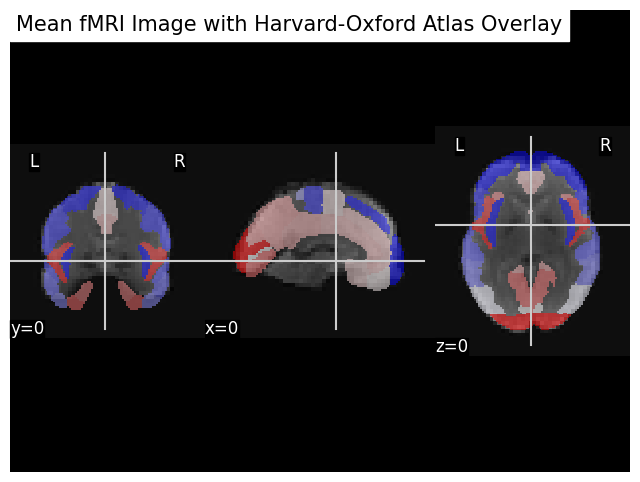

In [ ]:
from nilearn import plotting, image
import matplotlib.pyplot as plt

# Compute the mean fMRI image (across the time dimension)
mean_fmri_img = image.mean_img(fmri_filenames)

# Plot the mean fMRI image with the Harvard-Oxford atlas overlaid
# Adjusting the figure size here
fig, ax = plt.subplots(figsize=(8, 6))  # Smaller figure size
display = plotting.plot_anat(mean_fmri_img, display_mode='ortho',
                             title="Mean fMRI Image with Harvard-Oxford Atlas Overlay",
                             cut_coords=(0, 0, 0), axes=ax)
display.add_overlay(atlas_filename, cmap=plotting.cm.bwr, alpha=0.5)

# Show plot
plt.show()

Let's plot the mean time-series for each region to show this.

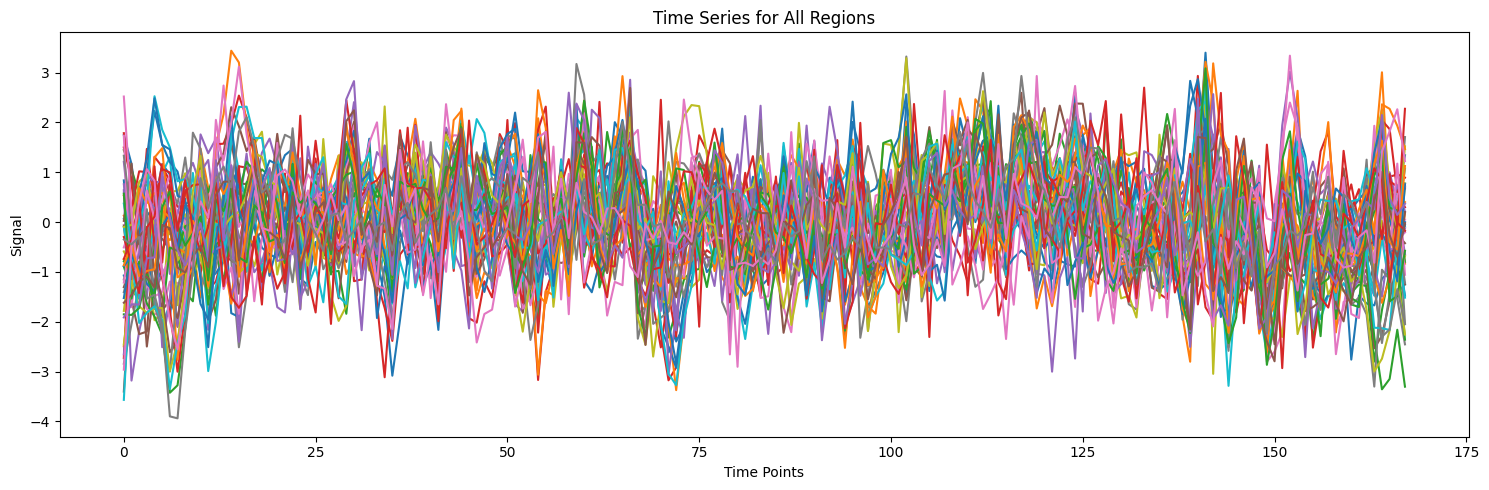

In [ ]:
import matplotlib.pyplot as plt

# Determine the number of unique regions
num_regions = len(labels) - 1

# Set up the figure size
plt.figure(figsize=(15, 5))  # Adjusted for better visualization in a single plot

# Plot the time series for each region on the same plot
for i in range(1, num_regions + 1):
    plt.plot(time_series[:, i - 1], label=labels[i])

plt.title('Time Series for All Regions')
plt.xlabel('Time Points')
plt.ylabel('Signal')
plt.tight_layout()

plt.show()

So, since our definition of functional connectivity is the degree of similarity between two timeseries, we can see regions that have a high and low connectivity by first identifying them by running a correlation across all regions and printing out which two regions have the highest and lowest:

In [ ]:
# Find the indices of the maximum and minimum value in the correlation matrix
max_corr = np.unravel_index(np.argmax(np.abs(correlation_matrix), axis=None), correlation_matrix.shape)
min_corr = np.unravel_index(np.argmin(np.abs(correlation_matrix[np.nonzero(correlation_matrix)])), correlation_matrix.shape)

# Extract indices for strongest and weakest connections
region1, region2 = max_corr
region1_weak, region2_weak = min_corr

print(f"The two regions with the strongest connectivity are {labels[region1]} and {labels[region2]}, with a correlation of {correlation_matrix[region1, region2]:.2f}.")
print(f"The two regions with the weakest connectivity are {labels[region1_weak]} and {labels[region2_weak]}, with a correlation of {correlation_matrix[region1_weak, region2_weak]:.2f}.")

The two regions with the strongest connectivity are Subcallosal Cortex and Paracingulate Gyrus, with a correlation of 0.81.
The two regions with the weakest connectivity are Superior Parietal Lobule and Superior Temporal Gyrus, posterior division, with a correlation of -0.02.


We can plot the mean connectivity across the region at each time-point. Remember that the degree of functional connectivity is most simply assessed by calculating the correlation coefficient between the time series of different brain regions. A high correlation coefficient (close to +1 or -1) indicates strong functional connectivity, while a coefficient close to 0 indicates weak or no functional connectivity.

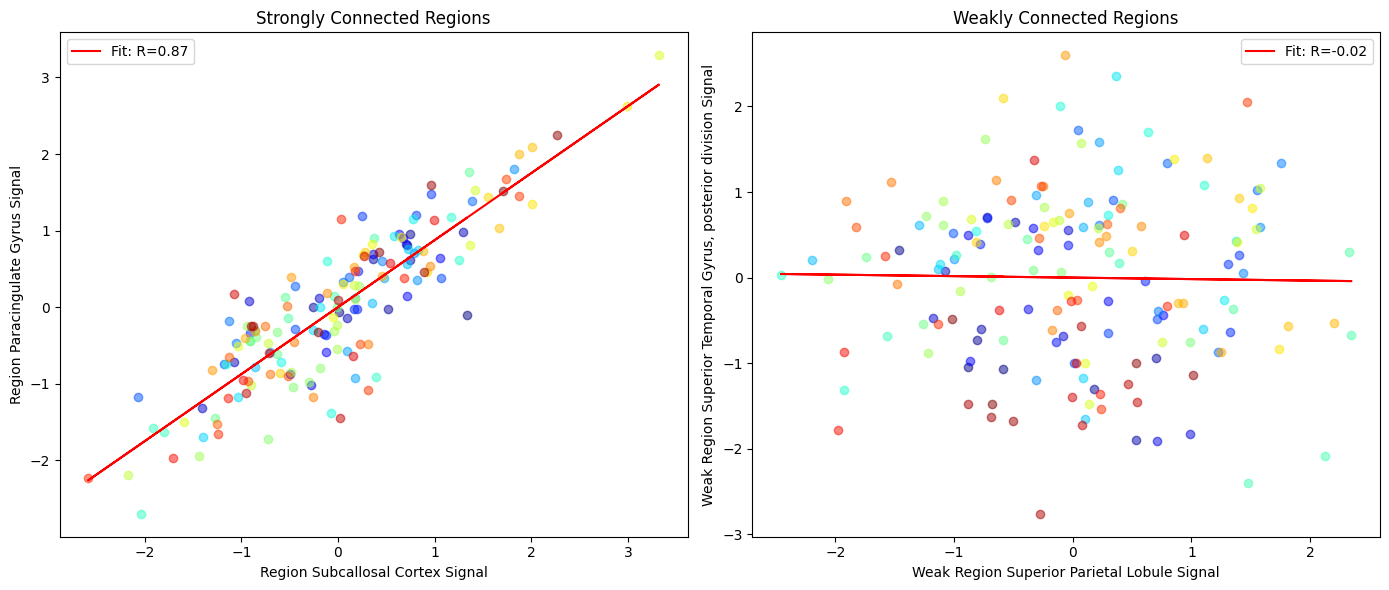

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Function to plot scatter graph with line of best fit and R value, with unique color for each time point
def plot_scatter_with_fit(x, y, labels, ax, title, line_color):
    # Calculate the line of best fit
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    line = slope * x + intercept

    # Generate a color map based on the length of x or y
    colors = plt.cm.jet(np.linspace(0, 1, len(x)))

    # Plot the scatter graph with a unique color for each time point
    for i in range(len(x)):
        ax.scatter(x[i], y[i], alpha=0.5, color=colors[i])
    ax.plot(x, line, color=line_color, label=f'Fit: R={r_value:.2f}')
    ax.set_xlabel(f"{labels[0]} Signal")
    ax.set_ylabel(f"{labels[1]} Signal")
    ax.set_title(title)
    ax.legend()

# Assuming time_series, labels, region1, region2, region1_weak, region2_weak are defined
time_series_region1 = time_series[:, region1]
time_series_region2 = time_series[:, region2]
time_series_region1_weak = time_series[:, region1_weak]
time_series_region2_weak = time_series[:, region2_weak]

# Set up a figure with two subplots side by side for scatter plots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

line_color = 'red'  # Color for the line of best fit

# Scatter plot for the two strongly connected regions with unique color for each time point
plot_scatter_with_fit(time_series_region1, time_series_region2,
                      [f"Region {labels[region1]}", f"Region {labels[region2]}"],
                      axes[0], 'Strongly Connected Regions',
                      line_color)

# Scatter plot for the two weakly connected regions with unique color for each time point
plot_scatter_with_fit(time_series_region1_weak, time_series_region2_weak,
                      [f"Weak Region {labels[region1_weak]}", f"Weak Region {labels[region2_weak]}"],
                      axes[1], 'Weakly Connected Regions',
                      line_color)

plt.tight_layout()
plt.show()


Each dot represents one TR in the time-series. The similarity is measured by the simiality between the signal in the same TRs across both regions.

To see this more clearly, we can plot the mean time-series for each region.

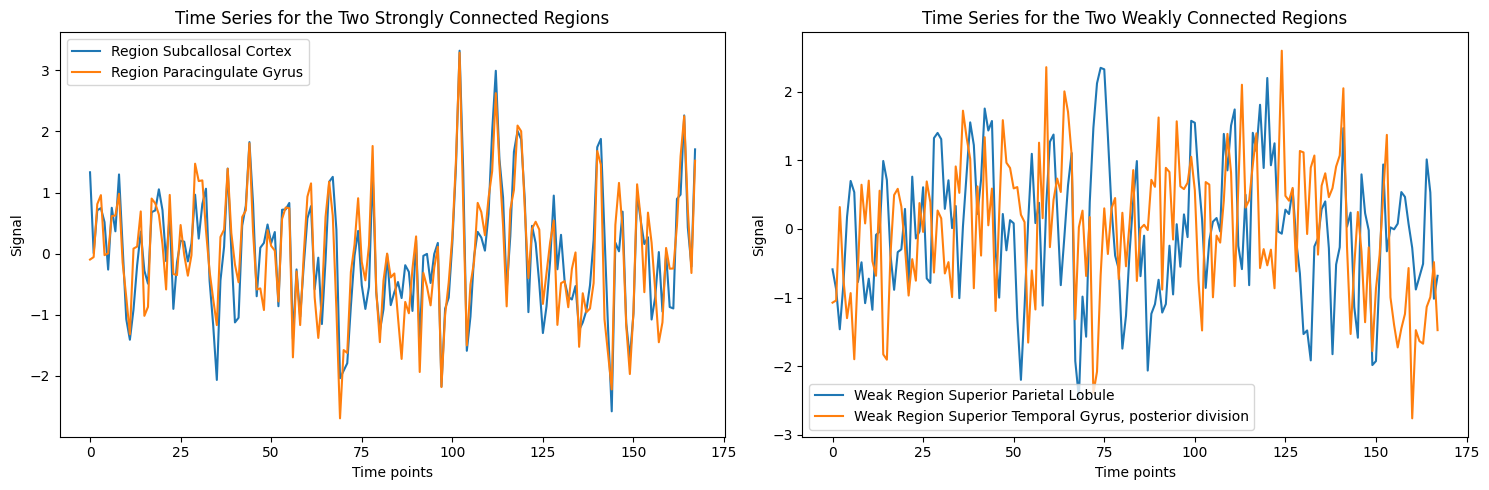

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming time_series, labels, region1, region2, region1_weak, region2_weak are defined from previous steps

# Extract the time series for the regions
time_series_region1 = time_series[:, region1]
time_series_region2 = time_series[:, region2]
time_series_region1_weak = time_series[:, region1_weak]
time_series_region2_weak = time_series[:, region2_weak]

# Set up a figure with two subplots side by side for time series
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot the time series for the two strongly connected regions on the first subplot
axes[0].plot(time_series_region1, label=f"Region {labels[region1]}")
axes[0].plot(time_series_region2, label=f"Region {labels[region2]}")
axes[0].set_xlabel('Time points')
axes[0].set_ylabel('Signal')
axes[0].set_title('Time Series for the Two Strongly Connected Regions')
axes[0].legend()

# Plot the time series for the two weakly connected regions on the second subplot
axes[1].plot(time_series_region1_weak, label=f"Weak Region {labels[region1_weak]}")
axes[1].plot(time_series_region2_weak, label=f"Weak Region {labels[region2_weak]}")
axes[1].set_xlabel('Time points')
axes[1].set_ylabel('Signal')
axes[1].set_title('Time Series for the Two Weakly Connected Regions')
axes[1].legend()

plt.tight_layout()
plt.show()

Functional connectivity analysis in this manner is correlational not causal, so we should be aware of that. However, for the purposes of our tutorial, this is just fine, and it is actually the same approach that the workshop tutorial uses.

So, let's give that a go!